## Import Libraries

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import string
import re
from nltk.stem import WordNetLemmatizer
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from wordcloud import WordCloud
import unicodedata
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

ModuleNotFoundError: No module named 'sklearn'

In [68]:
!pip uninstall sklearn

^C


# Data Preprocessing Steps

### Open CSV and analyze columns

In [8]:
df = pd.read_csv('../data/movies_database.csv', na_values=['#EMPTY?'])

# Fix the &apos; formatting problem
df['Description'] = df['Description'].str.replace("&apos;", "'")
df['Name'] = df['Name'].str.replace("&apos;", "'")
df['Keywords'] = df['Keywords'].str.replace("&apos;", "'")

df.head(5)

,Name,Date Published,Description,Rating,Rating Count,Content Rating,Genre(s),Keywords
0,9 to 5: Days in Porn,2009-07-02,NaN,6.3,2173.0,Not Rated,Documentary,"sex,female frontal nudity,female rear nudity,a..."
1,Stir Crazy,1981-09-03,NaN,6.7,29268.0,R,"Comedy,Crime","prison,prison yard,cell mate,woodpecker costum..."
2,The Blue Lagoon,1923-02-05,"In the Victorian period, two children are ship...",5.4,37.0,NaN,Drama,based on novel
3,Any Which Way You Can,1981-10-09,NaN,6.1,20075.0,PG,"Action,Comedy","sequel,machismo,vendetta,farce,abduction"
4,Smokey and the Bandit II,1981-08-14,NaN,5.2,16590.0,PG,"Action,Adventure,Comedy","sheriff,road movie,elephant,car crash,hixploit..."


In [9]:
df.dtypes

Name               object
Date Published     object
Description        object
Rating            float64
Rating Count      float64
Content Rating     object
Genre(s)           object
Keywords           object
dtype: object

In [10]:
df.isnull().sum()

Name                 0
Date Published    2638
Description       3697
Rating            2200
Rating Count      2200
Content Rating    3885
Genre(s)             0
Keywords          2373
dtype: int64

#### Drop null entries compare before and after

In [11]:
df["Name"].size

11809

In [25]:
df = df.dropna(subset=['Description'], axis=0)

In [26]:
df["Name"].size

8112

In [27]:
df.isnull().sum()

Name                 0
Date Published    2415
Description          0
Rating            2147
Rating Count      2147
Content Rating    3300
Genre(s)             0
Keywords          2257
dtype: int64

#### Remove repeated entries

In [28]:
df["Description"].size

8112

In [29]:
df = df.drop_duplicates(subset="Description")
df["Description"].size

7152

#### Encode Genre(s) Column 

In [30]:
dummies = df["Genre(s)"].str.get_dummies(sep=",")
df = pd.concat([df, dummies], axis=1)
df = df.drop("Genre(s)", axis=1)
pd.set_option("display.max_columns", None)
df.head(5)

,Name,Date Published,Description,Rating,Rating Count,Content Rating,Keywords,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
2,The Blue Lagoon,1923-02-05,"In the Victorian period, two children are ship...",5.4,37.0,NaN,based on novel,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,The Best of the Blues Brothers,NaN,Dan Aykroyd and friends tell the story of the ...,7.6,441.0,NaN,"actor playing multiple roles,independent film",0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7,The Gods Must Be Crazy,1982-09-09,A comic allegory about a traveling Bushman who...,7.3,57535.0,M/12,"junk,junk food,multinational corporation,pop,p...",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Star Wars: Episode IX - The Rise of Skywalker,2019-12-19,In the riveting conclusion of the landmark Sky...,6.5,462982.0,M/12,"evil,quicksand,space opera,star wars,disney st...",1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,National Lampoon's Animal House,1980-10-24,"At a 1962 college, Dean Vernon Wormer is deter...",7.4,124436.0,R,"academic probation,toga party,fraternity,stuff...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Data Analysis 

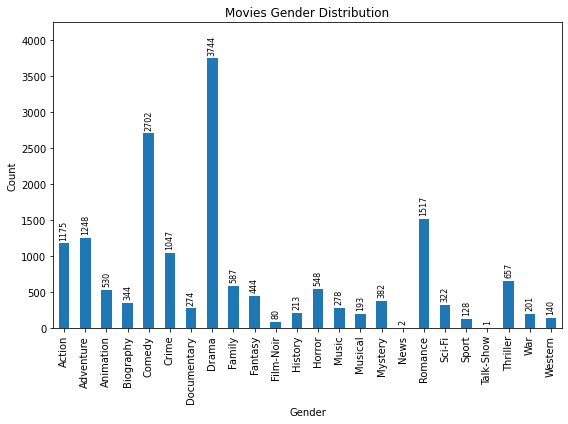

In [31]:
index_start = df.columns.get_loc('Action')
index_end = df.columns.get_loc('Western')
genders_df = df.iloc[:, index_start:index_end+1]
sum_genders = genders_df.sum()
sum_genders_df = sum_genders.to_frame()

# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
sum_genders_df.plot(kind="bar", ax=ax, legend=None)
ax.set_xlabel("Gender")
ax.set_ylabel("Count")
ax.set_title("Movies Gender Distribution")

# Add count labels to each bar
for i, v in enumerate(sum_genders_df.iloc[:, 0]):
    ax.text(i, v+50, str(v), ha='center', va='bottom', rotation=90, fontsize=8)

# Add padding to the y-axis limits
ax.set_ylim(0, max(sum_genders_df.iloc[:, 0])+500)

# Show the plot
plt.tight_layout()
plt.show()

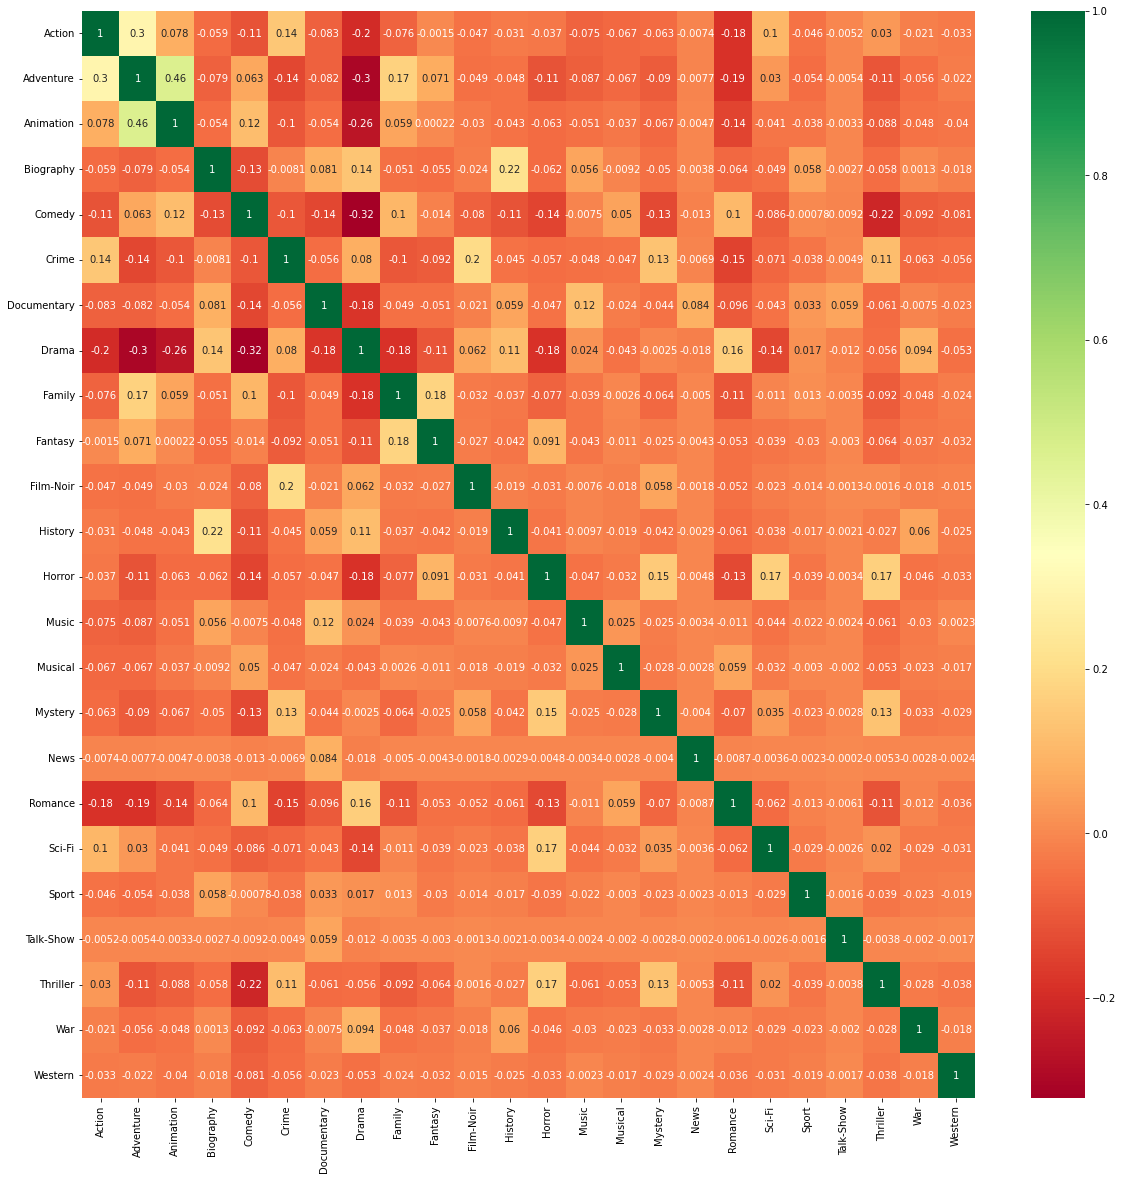

In [32]:
# Get the correlation matrix
index_start = df.columns.get_loc('Action')
index_end = df.columns.get_loc('Western')
corr_matrix = df.iloc[:, index_start:index_end+1].corr()

# Create a larger figure
fig, ax = plt.subplots(figsize=(20, 20))

# Create a heatmap using sns.heatmap
sns.heatmap(corr_matrix, annot=True, cbar=True, cmap='RdYlGn', ax=ax)

# Show the plot
plt.show()

<ipython-input-36-b80a99a143ad>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.index, rotation=0)


Dropdown(description='Genre:', options=('Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'D…

<Figure size 432x288 with 0 Axes>

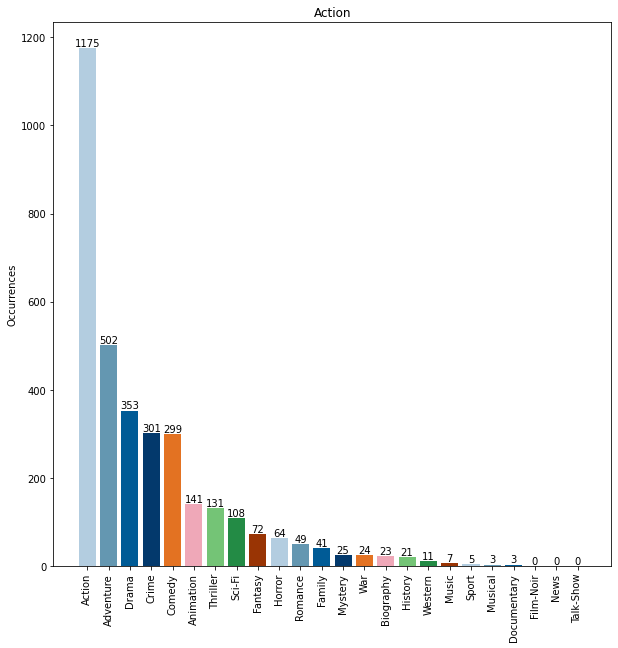

In [36]:
# Create a list of genres to select from
genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']

# Create the dropdown widget
genre_select = widgets.Dropdown(
    options=genres,
    description='Genre:',
    disabled=False
)

# Define the function to update the display based on the selected genre
def update_display(genre):
    plt.clf()  # clear the previous plot
    clear_output(wait=True)
    data = df.loc[df[genre] == 1, genres].sum().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.bar_label(ax.bar(data.index, data, color=['#b3cde0', '#6497b1', '#005b96', '#03396c', '#e37222', '#efa8b8', '#74c476', '#238b45', '#993404']), labels=data, label_type='edge')
    ax.set_title(genre)
    ax.set_ylabel('Occurrences')
    ax.set_xticklabels(data.index, rotation=0)
    plt.xticks(rotation=90)
    display(genre_select)
    plt.show()

# Display the widget and call the update_display function when the genre is changed
genre_select.observe(lambda change: update_display(change.new), names='value')
update_display('Action')

#### Drop entries with genre's that do not belong

In [37]:
genres_to_remove = ['News', 'Talk-Show'];
entries_to_remove = df.loc[(df[genres_to_remove] == 1).any(axis=1)]

df = df.drop(entries_to_remove.index, axis=0)
df.drop(genres_to_remove, axis=1, inplace=True)

index_start = df.columns.get_loc('Action')
index_end = df.columns.get_loc('Western')
df.iloc[:, index_start:index_end+1].sum()

Action         1175
Adventure      1248
Animation       530
Biography       344
Comedy         2702
Crime          1047
Documentary     271
Drama          3744
Family          587
Fantasy         444
Film-Noir        80
History         213
Horror          548
Music           278
Musical         193
Mystery         382
Romance        1517
Sci-Fi          322
Sport           128
Thriller        657
War             201
Western         140
dtype: int64

In [38]:
# List of columns to check for 0 values
index_start = df.columns.get_loc('Action')
index_end = df.columns.get_loc('Western')

df = df.drop(["Sport", "Film-Noir"], axis=1)

# Create a boolean condition to select rows where at least one column has a non-zero value
condition = (df.iloc[:, index_start:index_end+1] != 0).any(axis=1)

# Filter rows based on the condition
filtered_df = df[condition]

print("DF Size: ", df.size)
print("Filtered Size: ", filtered_df.size)

DF Size:  193023
Filtered Size:  192969


In [39]:
df['Action and Adventure'] = df[['Action', 'Adventure', 'War', 'Western']].max(axis=1)
df['Documentary and History'] = df[['Documentary', 'History', 'Biography']].max(axis=1)
df['Family and Animation'] = df[['Family', 'Animation']].max(axis=1)
df['Fantasy and Sci-Fi'] = df[['Fantasy', 'Sci-Fi']].max(axis=1)
df['Musical'] = df[['Music', 'Musical']].max(axis=1)
df['Horror and Thriller'] = df[['Horror', 'Thriller', 'Mystery']].max(axis=1)


df = df.drop(columns=['Action', 'Adventure', 'War', 'Western','Documentary', 'History', 'Biography','Family', 'Animation', 'Fantasy', 'Sci-Fi', 'Music', 'Musical', 'Horror', 'Thriller', 'Mystery'])

index_start = df.columns.get_loc('Comedy')
index_end = df.columns.get_loc('Horror and Thriller')
# Create a boolean condition to select rows where at least one column has a non-zero value
condition = (df.iloc[:, index_start:index_end+1] != 0).any(axis=1)

# Filter rows based on the condition
df = df[condition]

df.head(5)


,Name,Date Published,Description,Rating,Rating Count,Content Rating,Keywords,Comedy,Crime,Drama,Romance,Action and Adventure,Documentary and History,Family and Animation,Fantasy and Sci-Fi,Horror and Thriller
2,The Blue Lagoon,1923-02-05,"In the Victorian period, two children are ship...",5.4,37.0,NaN,based on novel,0,0,1,0,0,0,0,0,0
6,The Best of the Blues Brothers,NaN,Dan Aykroyd and friends tell the story of the ...,7.6,441.0,NaN,"actor playing multiple roles,independent film",0,0,0,0,0,1,0,0,0
7,The Gods Must Be Crazy,1982-09-09,A comic allegory about a traveling Bushman who...,7.3,57535.0,M/12,"junk,junk food,multinational corporation,pop,p...",1,0,0,0,1,0,0,0,0
8,Star Wars: Episode IX - The Rise of Skywalker,2019-12-19,In the riveting conclusion of the landmark Sky...,6.5,462982.0,M/12,"evil,quicksand,space opera,star wars,disney st...",0,0,0,0,1,0,0,1,0
9,National Lampoon's Animal House,1980-10-24,"At a 1962 college, Dean Vernon Wormer is deter...",7.4,124436.0,R,"academic probation,toga party,fraternity,stuff...",1,0,0,0,0,0,0,0,0


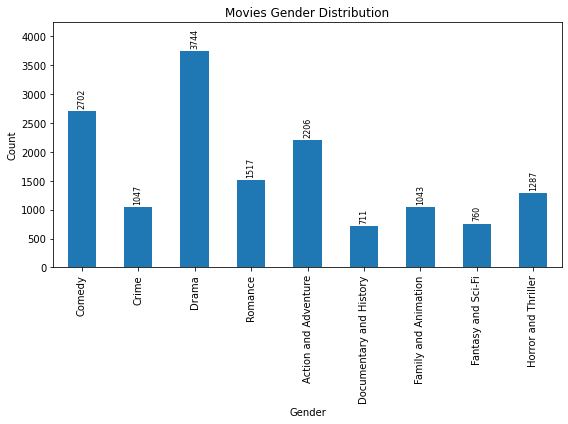

In [40]:
index_start = df.columns.get_loc('Comedy')
index_end = df.columns.get_loc('Horror and Thriller')
genders_df = df.iloc[:, index_start:index_end+1]
sum_genders = genders_df.sum()
sum_genders_df = sum_genders.to_frame()

# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
sum_genders_df.plot(kind="bar", ax=ax, legend=None)
ax.set_xlabel("Gender")
ax.set_ylabel("Count")
ax.set_title("Movies Gender Distribution")

# Add count labels to each bar
for i, v in enumerate(sum_genders_df.iloc[:, 0]):
    ax.text(i, v+50, str(v), ha='center', va='bottom', rotation=90, fontsize=8)

# Add padding to the y-axis limits
ax.set_ylim(0, max(sum_genders_df.iloc[:, 0])+500)

# Show the plot
plt.tight_layout()
plt.show()

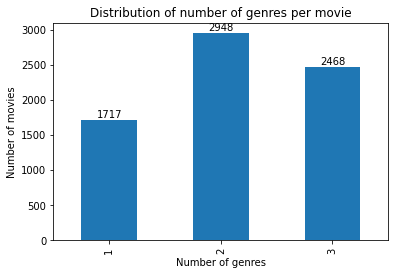

In [43]:
# Define the range of columns corresponding to the genres
index_start = df.columns.get_loc('Comedy')
index_end = df.columns.get_loc('Horror and Thriller')

# Count the number of genres for each movie
counts = df.iloc[:, index_start:index_end+1].apply(lambda row: row.astype(bool).sum(), axis=1).value_counts()

# Sort the counts by index (i.e., number of genres)
counts = counts.sort_index()

# Create a bar plot of the counts
ax = counts.plot.bar()
ax.set_xlabel('Number of genres')
ax.set_ylabel('Number of movies')
ax.set_title('Distribution of number of genres per movie')

# Add text labels with the count of movies for each bar
for i, count in enumerate(counts):
    ax.text(i, count+1, str(count), ha='center', va='bottom')

plt.show()

/var/folders/s2/457q439n0f54wwzhgtx6nzlw0000gn/T/ipykernel_45731/445688117.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.index, rotation=0)


Dropdown(description='Select a genre:', options=('Comedy', 'Crime', 'Drama', 'Romance', 'Action and Adventure'…

<Figure size 640x480 with 0 Axes>

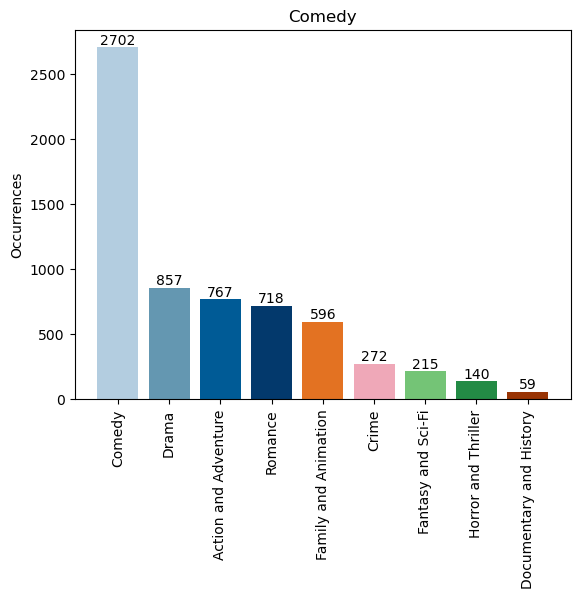

In [20]:
# Create a list of genres to select from
genres = ['Comedy', 'Crime', 'Drama', 'Romance', 'Action and Adventure', 'Documentary and History', 'Family and Animation', 'Fantasy and Sci-Fi', 'Horror and Thriller']

# Create the dropdown widget
genre_select = widgets.Dropdown(
    options=genres,
    description='Select a genre:',
    disabled=False
)

# Define the function to update the display based on the selected genre
def update_display(genre):
    plt.clf()  # clear the previous plot
    clear_output(wait=True)
    data = df.loc[df[genre] == 1, genres].sum().sort_values(ascending=False)
    fig, ax = plt.subplots()
    ax.bar_label(ax.bar(data.index, data, color=['#b3cde0', '#6497b1', '#005b96', '#03396c', '#e37222', '#efa8b8', '#74c476', '#238b45', '#993404']), labels=data, label_type='edge')
    ax.set_title(genre)
    ax.set_ylabel('Occurrences')
    ax.set_xticklabels(data.index, rotation=0)
    plt.xticks(rotation=90)
    display(genre_select)
    plt.show()

# Display the widget and call the update_display function when the genre is changed
genre_select.observe(lambda change: update_display(change.new), names='value')
update_display('Comedy')

## Keyword Extraction

In [59]:
def remove_accents(sentence):
    cleaned_sentence = unicodedata.normalize('NFD', sentence)
    cleaned_sentence = cleaned_sentence.encode('ascii', 'ignore')
    cleaned_sentence = cleaned_sentence.decode("utf-8")
    return cleaned_sentence

def remove_punctuation(sentence):
    cleaned_sentence = re.sub(r'[?|!|\'|"|#]', '', sentence)
    cleaned_sentence = re.sub(r'[,|.|;|:|(|)|{|}|\|/|<|>]|-', ' ', cleaned_sentence)
    cleaned_sentence = cleaned_sentence.replace("\n"," ")
    return cleaned_sentence

def keep_alpha(sentence):
    alpha_sentence = re.sub('[^a-z A-Z]+', ' ', sentence)
    return alpha_sentence

def stemming(sentence):
    stemmer = SnowballStemmer("english")
    stemmed_words = [stemmer.stem(word) for word in sentence.split()]
    stemmed_sentence=' '.join(stemmed_words)
    return stemmed_sentence

def lemmatize_words(sentence):
    lem = WordNetLemmatizer()
    lemmatized_words = [lem.lemmatize(word, 'v') for word in sentence.split()]
    lemmatized_sentence=' '.join(lemmatized_words)
    return lemmatized_sentence

def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))
    stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten',
                       'may','also','across','among','beside','however','yet','within','find'])
    no_stop_words=[word for word in sentence.split() if word not in stop_words]
    no_step_sentence = ' '.join(no_stop_words)
    return no_step_sentence

def text_preprocess(sentence):
    pre_processed_sentence = remove_accents(sentence)
    pre_processed_sentence = remove_punctuation(pre_processed_sentence)
    pre_processed_sentence = keep_alpha(pre_processed_sentence)
    pre_processed_sentence = lower_case(pre_processed_sentence)
    pre_processed_sentence = lemmatize_words(pre_processed_sentence)
    pre_processed_sentence = remove_stop_words(pre_processed_sentence)
    
    return pre_processed_sentence

def lower_case(sentence):
    lower_case_sentence = sentence.lower()
    return lower_case_sentence

df['Description Tokenized'] = df['Description'].apply(text_preprocess)

df['Keywords'] = df['Keywords'].fillna(" ")
df['Keywords'] = df["Keywords"].str.split(",")
tokenizer = RegexpTokenizer(r'[a-zA-z]+')
df['Description Tokenized'] = df.apply(lambda row: tokenizer.tokenize(row['Description Tokenized']), axis=1)
df['Description Tokenized'] = df['Description Tokenized']

df.head(5)

,Name,Date Published,Description,Rating,Rating Count,Content Rating,Keywords,Comedy,Crime,Drama,Romance,Action and Adventure,Documentary and History,Family and Animation,Fantasy and Sci-Fi,Horror and Thriller,Description Tokenized
2,The Blue Lagoon,1923-02-05,"In the Victorian period, two children are ship...",5.4,37.0,NaN,NaN,0,0,1,0,0,0,0,0,0,"[victorian, period, children, shipwreck, tropi..."
6,The Best of the Blues Brothers,NaN,Dan Aykroyd and friends tell the story of the ...,7.6,441.0,NaN,NaN,0,0,0,0,0,1,0,0,0,"[dan, aykroyd, friends, tell, story, famous, s..."
7,The Gods Must Be Crazy,1982-09-09,A comic allegory about a traveling Bushman who...,7.3,57535.0,M/12,NaN,1,0,0,0,1,0,0,0,0,"[comic, allegory, travel, bushman, encounter, ..."
8,Star Wars: Episode IX - The Rise of Skywalker,2019-12-19,In the riveting conclusion of the landmark Sky...,6.5,462982.0,M/12,NaN,0,0,0,0,1,0,0,1,0,"[rivet, conclusion, landmark, skywalker, saga,..."
9,National Lampoon's Animal House,1980-10-24,"At a 1962 college, Dean Vernon Wormer is deter...",7.4,124436.0,R,NaN,1,0,0,0,0,0,0,0,0,"[college, dean, vernon, wormer, determine, exp..."


Dropdown(description='Select a genre:', index=5, options=('Comedy', 'Crime', 'Drama', 'Romance', 'Action and A…

<Figure size 432x288 with 0 Axes>

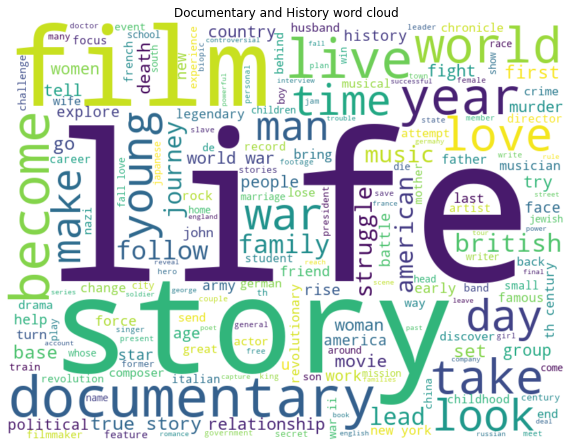

In [60]:
# Define the list of genres to select from
genres = ['Comedy', 'Crime', 'Drama', 'Romance', 'Action and Adventure', 'Documentary and History', 'Family and Animation', 'Fantasy and Sci-Fi', 'Horror and Thriller']

# Create a dropdown widget to select the genre
genre_select = widgets.Dropdown(
    options=genres,
    description='Select a genre:',
    disabled=False
)

# Define a function to generate the word cloud for the selected genre
def update_wordcloud(genre):
    plt.clf()  # clear the previous plot
    clear_output(wait=True)
    # Get the rows for the selected genre
    rows = df[df[genre] == 1]

    # Flatten the lists in the 'Description Tokenized' column into a single string
    text = ' '.join([word for sublist in rows['Description Tokenized'] for word in sublist])

    # Create a word cloud object
    wc = WordCloud(background_color='white', width=800, height=600)

    # Generate the word cloud
    wc.generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{genre} word cloud')
    display(genre_select)
    plt.show()

# Display the dropdown widget and call the update_wordcloud function when the genre is changed
genre_select.observe(lambda change: update_wordcloud(change.new), names='value')
update_wordcloud("Comedy")

In [69]:
genres = ['Comedy', 'Crime', 'Drama', 'Romance', 'Action and Adventure', 'Documentary and History', 'Family and Animation', 'Fantasy and Sci-Fi', 'Horror and Thriller']
X = df['Description']
y = df[genres]

# Determine the minimum number of samples across all classes
min_samples = y.sum().min()

# Shuffle the dataset and keep only the minimum number of samples for each class
samples_per_class = {}
for genre in genres:
    class_samples = df[df[genre] == 1].sample(min_samples, random_state=42)
    samples_per_class[genre] = class_samples
df_balanced = pd.concat(samples_per_class.values())

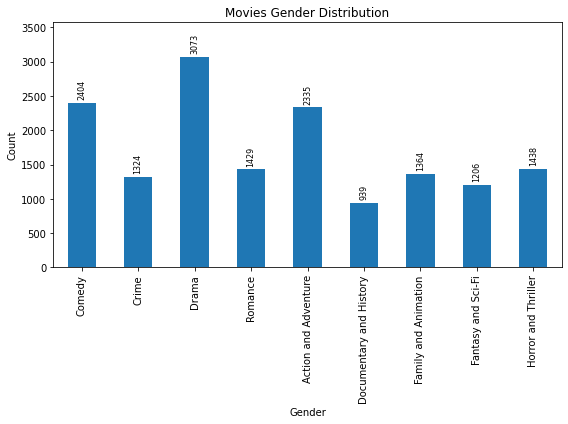

In [70]:
index_start = df_balanced.columns.get_loc('Comedy')
index_end = df_balanced.columns.get_loc('Horror and Thriller')
genders_df = df_balanced.iloc[:, index_start:index_end+1]
sum_genders = genders_df.sum()
sum_genders_df = sum_genders.to_frame()

# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
sum_genders_df.plot(kind="bar", ax=ax, legend=None)
ax.set_xlabel("Gender")
ax.set_ylabel("Count")
ax.set_title("Movies Gender Distribution")

# Add count labels to each bar
for i, v in enumerate(sum_genders_df.iloc[:, 0]):
    ax.text(i, v+50, str(v), ha='center', va='bottom', rotation=90, fontsize=8)

# Add padding to the y-axis limits
ax.set_ylim(0, max(sum_genders_df.iloc[:, 0])+500)

# Show the plot
plt.tight_layout()
plt.show()

In [74]:
df_balanced.to_csv('../data/balanced.csv', index=False)
df_export = df_balanced.drop(columns=["Date Published", "Rating", "Rating Count", "Content Rating", "Keywords", "Description"])

In [75]:
df_export.to_csv('../data/test.csv', index=False)

In [76]:
df_export.head(5)

,Name,Comedy,Crime,Drama,Romance,Action and Adventure,Documentary and History,Family and Animation,Fantasy and Sci-Fi,Horror and Thriller,Description Tokenized
4510,Home for the Holidays,1,0,1,1,0,0,0,0,0,"[lose, job, make, soon, former, boss, daughter..."
7409,Dentist on the Job,1,0,0,0,0,0,0,0,0,"[market, department, pharmaceutical, company, ..."
6599,"One, Two, Three",1,0,0,0,0,0,0,0,0,"[west, berlin, cold, war, coca, cola, executiv..."
5959,Man of the Century,1,0,0,1,0,0,0,0,0,"[fantasy, comedy, young, man, live, encounter,..."
10686,Monte Carlo,1,0,0,0,1,0,1,0,0,"[young, women, vacation, paris, whisk, away, m..."
